In [18]:
!nvidia-smi

Mon Dec 13 09:02:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:5E:00.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:D8:00.0 Off |                    0 |
| N/A   

In [19]:
import numpy as np
from tqdm.notebook import tqdm

In [1]:
import os
import re
from conllu import parse_incr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

files = {'train': ['ru_syntagrus-ud-train-a.conllu', 'ru_syntagrus-ud-train-b.conllu', 'ru_syntagrus-ud-train-c.conllu'],
         'test':  ['ru_syntagrus-ud-test.conllu'],
         'dev':   ['ru_syntagrus-ud-dev.conllu']}

labels = []
sentences = []
for data_type in files:
    for filename in files[data_type]: 
        with open(os.path.join('UD_Russian-SynTagRus', filename), encoding='utf-8') as f:
            parsed = parse_incr(f)
            for token_list in parsed:
                topic_name = token_list.metadata['sent_id'].split('.')[0]
                # уберём цифры из названий темы
                topic_name = re.sub(r'\d+', '', topic_name)
                sentence = ' '.join([token['form'] for token in token_list]).lower()
                labels.append(topic_name)
                sentences.append(sentence)

le = LabelEncoder()
ohe = OneHotEncoder()
ohe.fit(le.fit_transform(labels).reshape(-1, 1))

labels = np.array(labels)
sentences = np.array(sentences)

NameError: name 'np' is not defined

In [21]:
max_len = -1
lengths = []
for message in sentences:
    max_len = len(message.split()) if len(message.split()) > max_len else max_len
    lengths.append(len(message.split()))
max_len

205

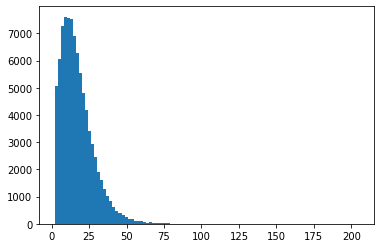

In [22]:
import matplotlib.pyplot as plt
plt.hist(lengths, bins=100)
plt.show()

In [23]:
TARGET_LEN = 52
EMBEDDING_SIZE = 200

# !!!ЭМБЕДИНГИ НЕ КАЧЕСТВЕННЫЕ, не сдавайся

In [24]:
import pickle
with open('word2vec_100.pkl', 'rb') as rf:
    W2V_100 = pickle.load(rf)
with open('fasttext_100.pkl', 'rb') as rf:
    FT_100 = pickle.load(rf)

In [25]:
W2V_100.wv.most_similar(positive='.'), FT_100.wv.most_similar('я')

([('накрахмаленных', 0.81927490234375),
  (';', 0.8096592426300049),
  ('рядовыми', 0.8064565062522888),
  ('чеченская', 0.7928946018218994),
  ('соцстранах', 0.7922433614730835),
  ('дымящих', 0.7861340641975403),
  ('одиночного', 0.7822094559669495),
  ('наркотикам', 0.7802185416221619),
  ('линейный', 0.7785296440124512),
  ('качественную', 0.7770684361457825)],
 [('он', 0.9201070070266724),
  ('уж', 0.8810179829597473),
  ('мыл', 0.8596895933151245),
  ('мышь', 0.8507342338562012),
  ('онф', 0.8464065194129944),
  ('мне', 0.8424739241600037),
  ('даешь', 0.838414192199707),
  ('он-лайн', 0.8318077921867371),
  ('ешь', 0.8273506760597229),
  ('да', 0.8267568349838257)])

In [26]:
def pad_sequences(sequence, target_len: int=20, embedding_size: int=300) -> np.array:
    sequence = np.array(sequence)
    if sequence.size == 0:
        # empty array
        current_length = 0
        return np.zeros((target_len, embedding_size))
    elif len(sequence.shape) == 1:
        sequence = np.array([sequence])
        current_length = 1
    else:
        current_length = sequence.shape[0]
        
    if current_length >= target_len:
        return sequence[-target_len:]
    
    padding = np.random.uniform(size=(target_len - current_length, embedding_size))
    #padding = np.zeros((target_len - current_length, embedding_size))
    return np.concatenate((padding, sequence), axis=0)

In [27]:
from tqdm.notebook import tqdm
def vectorize_sentence(sentence):
    vec = []
    for token in sentence.split():
        tkn_vec = np.concatenate((W2V_100.wv[token], FT_100.wv[token]), axis=0)
        vec.append(tkn_vec)
    return pad_sequences(vec, target_len=TARGET_LEN, embedding_size=EMBEDDING_SIZE)

In [28]:
RANDOM_DIM = 100


class DataGenerator():
    def __init__(self, labels, sentences, batches_per_epoch, batch_size):
        self.train_sentences = sentences
        self.train_labels = labels
        self.batches_per_epoch = batches_per_epoch
        self.batch_size = batch_size
    
    @staticmethod
    def rand_norm(npoints=1, ndim=RANDOM_DIM):
        rand_vec = np.random.normal(0, 1, size=[npoints, ndim])
        return rand_vec

    def __len__(self):
        return self.batches_per_epoch

    def batch(self):
        rand_sentences_indexes = np.random.randint(0, self.train_sentences.shape[0], size=self.batch_size)
        sent_batch = np.array([vectorize_sentence(sent) for sent in self.train_sentences[rand_sentences_indexes]])
        labels_batch = ohe.transform(le.transform(self.train_labels[rand_sentences_indexes]).reshape(-1, 1))
        return sent_batch, labels_batch

    def __iter__(self):
        for b in tqdm(range(self.batches_per_epoch), leave=False):
            yield self.batch()

    def rand_batch(self):
        rand_vec = self.rand_norm(self.batch_size)
        # for training generator with label
        rand_labels = np.random.randint(0, len(le.classes_), size=[self.batch_size])
        rand_labels = ohe.transform(rand_labels.reshape(-1, 1)).todense()
        return (rand_vec, rand_labels)

    
np.random.seed(42)
sent_indexes = np.random.randint(0, len(sentences), size=3)
MESSAGES_FROM_DATASET = [sentences[sent_indexes], labels[sent_indexes]]
FIXED_NOISE = (DataGenerator.rand_norm(3), ohe.transform(le.transform(labels[sent_indexes]).reshape(-1, 1)).todense())
MESSAGES_FROM_DATASET

[array(['осенью россия уже пережила микрокризис ликвидности ( проще говоря , нехватку свободных денег ) .',
        'жизнь ! . .',
        'они купили примерно 75 % прироста внутреннего госдолга .'],
       dtype='<U1218'),
 array(['Bankovskii_krizis', 'Baklanov', 'Dvadtsat_let_defoltu'],
       dtype='<U53')]

# GENERATOR

In [29]:
import torch

def give_pe(batch_size, seq_len, features):
    '''positiona encoding'''
    # create constant 'pe' matrix with values dependant on 
    # seq_length and features
    pe = torch.linspace(-1, 1, seq_len)
    pe = pe.repeat(batch_size, features, 1)
    pe = torch.transpose(pe, dim0=1, dim1=2)
    position = torch.linspace(0.1, 1, features)
    position = position.repeat(batch_size, seq_len, 1)
    pe = torch.mul(pe, position)
    pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2])
    pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2])
    return pe


give_pe(1, 2, 3)

tensor([[[-0.0998,  0.8525, -0.8415],
         [ 0.0998,  0.8525,  0.8415]]])

In [30]:
import torch

class Generator(torch.nn.Module):
    def __init__(self, complexity=180):
        super(Generator, self).__init__()
        self.complexity = int(complexity)
        # LAYER 1
        self.fc_1 = torch.nn.Linear(
            in_features=RANDOM_DIM + len(le.classes_),
            out_features=TARGET_LEN//2//2*self.complexity,
        )
        self.init_small_std(self.fc_1)
        self.activation_1 = torch.nn.LeakyReLU(negative_slope=0.2)
        
        # LAYER 2
        self.con1dT_2 = torch.nn.ConvTranspose1d(
            in_channels=TARGET_LEN//2//2,
            out_channels=TARGET_LEN//2,
            kernel_size=3
        )
        self.init_small_std(self.con1dT_2)
        self.batch_norm_2 = torch.nn.BatchNorm1d(
            num_features=TARGET_LEN//2
        )
        self.activation_2 = torch.nn.LeakyReLU(negative_slope=0.2)
        
        # LAYER 3
        self.con1dT_3 = torch.nn.ConvTranspose1d(
            in_channels=TARGET_LEN//2,
            out_channels=TARGET_LEN,
            kernel_size=3
        )
        self.init_small_std(self.con1dT_3)
        self.batch_norm_3 = torch.nn.BatchNorm1d(
            num_features=TARGET_LEN
        )
        self.activation_3 = torch.nn.LeakyReLU(negative_slope=0.2)
        
        # LAYER 4
        self.pe = give_pe(1, TARGET_LEN, self.complexity + 4)
#         self.lstm_4 = torch.nn.LSTM(
#             input_size=(self.complexity + 4)*2,
#             hidden_size=self.complexity,
#             bidirectional=True,
#         )
#         self.init_small_std(self.lstm_4)
#         self.batch_norm_4 = torch.nn.BatchNorm1d(
#             num_features=TARGET_LEN
#         )
#         self.activation_4 = torch.nn.Sigmoid()
        
        # LAYER 5
        self.fc_5 = torch.nn.Linear(
            #in_features=self.complexity * 2,
            in_features=(self.complexity + 4)*2,
            out_features=self.complexity * 2,
        )
        self.init_small_std(self.fc_5)
        self.activation_5 = torch.nn.LeakyReLU()
        
        # LAYER 6
        self.fc_6 = torch.nn.Linear(
            in_features=self.complexity * 2,
            out_features=EMBEDDING_SIZE,
        )
        self.init_small_std(self.fc_6)

        #self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.is_real_loss = torch.nn.BCELoss()
        self.category_loss = torch.nn.CrossEntropyLoss()
        
        print(
            'total trainable params:',
            sum(p.numel() for p in self.parameters() if p.requires_grad),
        )

    def init_small_std(self, nn_module):
        for p in nn_module.parameters():
            torch.nn.init.normal_(p, std=0.02)

    def forward(self, random_vec, labels):
        random_vec_labels = torch.Tensor(random_vec), torch.Tensor(labels)
        inp = torch.cat(random_vec_labels, 1)
        
        # LAYER 1
        # (batch_size x (RANDOM_DIM + ohe_classes))
        inp = self.fc_1(inp)
        # (batch_size x (complexity * TARGET_LEN/2/2))
        inp = self.activation_1(inp)
        # (batch_size x (complexity * TARGET_LEN/2/2))
        inp=torch.reshape(inp, (inp.shape[0], TARGET_LEN//2//2, self.complexity))
        
        # LAYER 2
        # (batch_size x 13 x complexity)
        inp = self.con1dT_2(inp)
        # (batch_size x 26 x 66)
        inp = self.batch_norm_2(inp)
        # (batch_size x 26 x 66)
        inp = self.activation_2(inp)
        
        # LAYER 3
        # (batch_size x 26 x complexity + 2)
        inp = self.con1dT_3(inp)
        # (batch_size x 52 x complexity + 4)
        inp = self.batch_norm_3(inp)
        # (batch_size x 52 x complexity + 4)
        inp = self.activation_3(inp)
        
        
        # LAYER 4
        # (batch_size x 52 x complexity + 4)
        inp = torch.cat((inp, self.pe.repeat((len(inp), 1, 1))), 2)
#         inp, _ = self.lstm_4(inp)
#         # (batch_size x 52 x 2*complexity)
#         inp = self.batch_norm_4(inp)
#         # (batch_size x 52 x 2*complexity)
#         inp = self.activation_4(inp)
        
        # LAYER 5
        # (batch_size x 52 x 2*complexity)
        inp = self.fc_5(inp)
        inp = self.activation_5(inp)
        
        # LAYER 6
        # (batch_size x 52 x 2*complexity)
        inp = self.fc_6(inp)
        
        return inp

generator = Generator()
generated_from_noise = generator.forward(*FIXED_NOISE)
generated_from_noise.shape

total trainable params: 1801544


torch.Size([3, 52, 200])

In [31]:
from scipy.spatial.distance import cosine


def message_recovery_with_metric(vector: np.ndarray):
    assert len(vector.shape) == 2
    tokens = []
    metric = []
    vector = vector.cpu().detach().numpy()
    for token_vec in vector:
        w2v = token_vec[:100]
        token = W2V_100.wv.most_similar([w2v])[0][0]
        tokens.append(token)
        
        metric.append(cosine(token_vec[100:], FT_100.wv[token]))
    return ' '.join(tokens[-10:]), np.mean(metric)



for example in generated_from_noise:
    print(message_recovery_with_metric(example))

('переизбирается персидским вздоха упрека вздоха упрека отборочную напряжен отличиях бюджетниками', 0.9921572180509639)
('долетает официанты вздоха поравнявшись гимны пожалел следователем слабел дневальный здравствующих', 1.0022923005476163)
('предпочел полигамии упрека вздоха дневальный вздоха поравнявшись обнимался упрека мокро', 0.9932869984639603)


# DISCRIMINATOR

In [32]:
class Discriminator(torch.nn.Module):
    def __init__(self, complexity=120):
        super(Discriminator, self).__init__()
        self.complexity = int(complexity)
        # LAYER 1
#         self.lstm_1 = torch.nn.LSTM(
#             input_size=EMBEDDING_SIZE,
#             hidden_size=self.complexity,
#             bidirectional=True,
#         )
        #self.dropout_1 = torch.nn.Dropout2d(p=0.2)
        #self.activation_1 = torch.nn.LeakyReLU(negative_slope=0.2)
        
        # LAYER 2
        self.conv1D_2 = torch.nn.ConvTranspose1d(
            in_channels=TARGET_LEN,
            out_channels=self.complexity,
            kernel_size=3,
            stride=2,
        )
        self.dropout_2 = torch.nn.Dropout2d(p=0.2)
        self.activation_2 = torch.nn.LeakyReLU(negative_slope=0.2)
        
        # LAYER 3
        self.conv1D_3 = torch.nn.ConvTranspose1d(
            in_channels=self.complexity,
            out_channels=self.complexity//2,
            kernel_size=3,
            stride=2,
        )
        self.dropout_3 = torch.nn.Dropout2d(p=0.2)
        self.activation_3 = torch.nn.LeakyReLU(negative_slope=0.2)
        
        # LAYER 4
        self.fc_4 = torch.nn.Linear(
            in_features=803,#(self.complexity*4+1)*2+1,
            out_features=self.complexity*2,
        )
        self.activation_4 = torch.nn.LeakyReLU(negative_slope=0.2)
        self.flatten_4 = torch.nn.Flatten(start_dim=1)
        
        # LAYER 5
        self.fc_5 = torch.nn.Linear(
            in_features=self.complexity*self.complexity,
            out_features=self.complexity,
        )
        self.activation_5 = torch.nn.LeakyReLU(negative_slope=0.2)   
        
        
        # LAYER 6_1
        self.fc_6_1 = torch.nn.Linear(
            in_features=self.complexity,
            out_features=1,
        )
        self.flatten_6_1 = torch.nn.Flatten(start_dim=0)
        self.activation_6_1 = torch.nn.Sigmoid()
        
        # LAYER 6_2
        self.fc_6_2 = torch.nn.Linear(
            in_features=self.complexity,
            out_features=len(le.classes_),
        )
        self.activation_6_2 = torch.nn.Softmax(dim=-1)
        
        self.is_real_loss = torch.nn.BCELoss()
        self.category_loss = torch.nn.CrossEntropyLoss()

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        print(
            'total trainable params:',
            sum(p.numel() for p in self.parameters() if p.requires_grad),
        )
        

    def forward(self, sentence_vec):
        inp = sentence_vec
        
#         # LAYER 1
#         # (batch_size x target_len x embedding_size)
#         inp, _ = self.lstm_1(inp)
#         # (batch_size x target_len x complexity*2)
#         inp = self.dropout_1(inp)
#         # (batch_size x target_len x complexity*2)
#         inp = self.activation_1(inp)

        # LAYER 2
        # (batch_size x target_len x complexity*2)
        inp = self.conv1D_2(inp)
        # (batch_size x target_len/2 x complexity*2)
        inp = self.dropout_2(inp)
        # (batch_size x target_len/2 x complexity*2)
        inp = self.activation_2(inp)
        
        # LAYER 3
        # (batch_size x target_len x complexity*2)
        inp = self.conv1D_3(inp)
        # (batch_size x target_len/4 x complexity)
        inp = self.dropout_3(inp)
        # (batch_size x target_len/4 x complexity)
        inp = self.activation_3(inp)
        
        
        # LAYER 4
        # (batch_size x target_len/4 x complexity)
        inp = self.fc_4(inp)
        # (batch_size x target_len/4 x complexity)
        inp = self.activation_4(inp)
        # (batch_size x target_len/4 x complexity)
        inp = self.flatten_4(inp)
        # (batch_size x target_len/4  complexity)
        
        # LAYER 5
        # (batch_size x complexity * 2)
        inp = self.fc_5(inp)
        # (batch_size x complexity)
        inp = self.activation_5(inp)
        
        # LAYER 6_1
        # (batch_size x complexity)
        inp_1 = self.fc_6_1(inp)
        inp_1 = self.flatten_6_1(inp_1)
        # (batch_size x 2)
        inp_1 = self.activation_6_1(inp_1)
        
        # LAYER 6_2
        # (batch_size x complexity)
        inp_2 = self.fc_6_2(inp)
        # (batch_size x 2)
        inp_2 = self.activation_6_2(inp_2)
        return inp_1, inp_2
    
    def train_on_batch(self, messages, y_real_fake, y_label):
        messages = torch.Tensor(messages)
        pred_real_fake, pred_label = self.forward(messages)
        self.optimizer.zero_grad()
        loss = self.is_real_loss(y_real_fake, pred_real_fake) + 0.01 * self.category_loss(y_label, pred_label)
        loss.backward()
        self.optimizer.step()
        accuracy = torch.mean(((pred_real_fake > 0.5).int() == (y_real_fake > 0.5).int()).float())
        return loss, accuracy


discriminator = Discriminator()
discriminator.forward(generated_from_noise)

total trainable params: 2031760


(tensor([0.5156, 0.5148, 0.5156], grad_fn=<SigmoidBackward0>),
 tensor([[0.0016, 0.0016, 0.0016,  ..., 0.0018, 0.0019, 0.0017],
         [0.0016, 0.0016, 0.0016,  ..., 0.0018, 0.0019, 0.0017],
         [0.0016, 0.0016, 0.0016,  ..., 0.0018, 0.0019, 0.0017]],
        grad_fn=<SoftmaxBackward0>))

# BUILDING GAN

In [33]:
class GAN(torch.nn.Module):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        
    def train_generator_on_batch(self, noise, y_real_fake, y_label):
        sentence = self.generator.forward(*noise)
        pred_real_fake, pred_label = self.discriminator.forward(sentence)
        loss_1 = self.discriminator.is_real_loss(y_real_fake, pred_real_fake)
        loss_2 = self.discriminator.category_loss(torch.Tensor(y_label), pred_label)
        loss = loss_1 + 0.01 * loss_2
        # self.generator.optimizer.zero_grad()
        loss.backward()
        self.generator.optimizer.step()
        accuracy = torch.mean(((pred_real_fake > 0.5).int() == (y_real_fake > 0.5).int()).float()).numpy()
        return loss, accuracy

gan = GAN(generator, discriminator)

In [34]:
generator_acc_follow = []
generator_accuracy_cumulative = 0.5
discriminator_accuracy_cumulative = 0.5
loss_cumulative = 1
BATCH_SIZE = 32
data = DataGenerator(labels, sentences, batches_per_epoch=2000, batch_size=BATCH_SIZE)

for epoch in range(100):
    for sent_batch, labels_batch in data:
        ##########################
        # discriminator training #
        ##########################
        noise = data.rand_batch()
        generated_texts = generator.forward(*noise)
        # X
        X = torch.cat((torch.Tensor(sent_batch), generated_texts), 0)
        # target valuest smoothing
        y_real = np.random.uniform(0.8, 1, size=[BATCH_SIZE])
        y_fake = np.random.uniform(0, 0.2, size=[BATCH_SIZE])
        # Y
        y_real_fake = torch.Tensor(np.concatenate((y_real, y_fake)))
        y_labels = torch.cat((
            torch.Tensor(labels_batch.todense()),
            torch.Tensor(np.zeros((BATCH_SIZE, len(le.classes_)))),
        ), 0)        
        
        loss, accuracy = discriminator.train_on_batch(X, y_real_fake, y_labels)
        discriminator_accuracy_cumulative = 0.9 * discriminator_accuracy_cumulative + 0.1 * accuracy
        generator_accuracy_cumulative = 1 - generator_accuracy_cumulative
        
        ######################
        # generator training #
        ######################
        while discriminator_accuracy_cumulative > 0.5:
            noise = data.rand_batch()
            # target values
            y_real_fake = torch.Tensor(np.random.uniform(0.9, 1.0, size=[BATCH_SIZE]))

            # train GAN and save accuracy to array
            loss, accuracy = gan.train_generator_on_batch(noise, y_real_fake, noise[1])

            generator_accuracy_cumulative = 0.9 * generator_accuracy_cumulative + 0.1 * accuracy
            discriminator_accuracy_cumulative = 1 - generator_accuracy_cumulative
            print('1', loss, '\t', generator_accuracy_cumulative, '\t', discriminator_accuracy_cumulative, '\t', end='\r')
        print('2', loss, '\t', generator_accuracy_cumulative, '\t', discriminator_accuracy_cumulative, '\t', end='\r') 
#         for p in discriminator.parameters():
#             print(p[-1].shape, p[-1][:10])
#             break
#     break
    print()
    if epoch%10==0:
        generated_from_noise = generator.forward(*FIXED_NOISE)
        for example in generated_from_noise:
            print(message_recovery_with_metric(example))
        

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [61]:
for sent, lbl in data:
    print(sent[0][0])
    print(sent[0][-1])
    break

  0%|          | 0/20 [00:00<?, ?it/s]

[0.06458079 0.88444217 0.04627904 0.01625815 0.47432459 0.76541899
 0.12418893 0.24392195 0.28025692 0.76642438 0.6068362  0.07439028
 0.06757367 0.41487956 0.76637193 0.58697913 0.65224034 0.97039418
 0.5478836  0.11985323 0.72954896 0.64719638 0.95548785 0.3016512
 0.22289601 0.06568971 0.9324067  0.61725998 0.17226599 0.45509105
 0.74441921 0.11003214 0.6409427  0.92842726 0.40769911 0.01004235
 0.07875389 0.33903056 0.67638938 0.07533897 0.68827802 0.03807154
 0.73976101 0.27656204 0.50372155 0.30466523 0.67049912 0.43468589
 0.88435819 0.31126294 0.69641774 0.87996534 0.03831658 0.78288389
 0.32955603 0.14168164 0.63375975 0.97035296 0.67075908 0.52466526
 0.04520703 0.96242532 0.47869339 0.514479   0.69143258 0.35431984
 0.37044873 0.61572151 0.44142991 0.06722276 0.84994126 0.22030675
 0.29160039 0.66756081 0.33088835 0.53921697 0.91767782 0.75352843
 0.02509498 0.53808318 0.87084049 0.08328986 0.54560594 0.95591056
 0.4870287  0.09907154 0.15488052 0.91138416 0.93317906 0.01248

In [62]:
data = DataGenerator(labels, sentences, batches_per_epoch=20, batch_size=3)
for sentence, label in data:
    break

  0%|          | 0/20 [00:00<?, ?it/s]

In [63]:
sentence[0][-1]

array([-0.99833584,  0.02226288, -0.70911545, -0.56301022, -0.24518657,
        0.33840847,  1.88200688, -0.08435501,  0.99568427,  0.1722375 ,
        0.48785657,  0.4074074 ,  0.6538142 , -0.22701219, -1.25403476,
       -1.54989266, -0.60041094, -1.29876709, -2.54407263, -1.52077937,
        0.56938231, -1.38847923,  0.94856429,  0.21916068,  0.53763741,
       -0.483953  , -0.24481063,  1.10400212, -0.35310096, -0.88286704,
        0.74152726,  0.29003257,  1.08094084,  0.70721066,  1.63394225,
        0.70530182, -0.29778716, -0.84324068,  1.37909079, -0.70705599,
        1.30713356,  0.26339796, -0.57403082, -1.44039404, -1.03593075,
       -0.21261756,  0.88047528,  0.20621392,  0.40647823, -0.03818775,
       -0.05348476, -1.69562638, -1.55464637,  0.20927456, -0.85950965,
        0.24430278,  1.92697787, -1.39320064, -1.67942941, -0.75467837,
       -0.1933718 ,  0.35632777, -0.05327565, -2.84187245,  1.1999284 ,
       -0.18148756, -0.49709737,  0.32397431, -0.63812035, -0.26

In [64]:
generated_from_noise = generator.forward(*FIXED_NOISE)
generated_from_noise[-1][-1]

tensor([-1680.9456,  4165.1724,  1533.1951,  7199.9072,  5070.6938,  2345.7065,
         9250.3389,  5203.1479,  4259.1182,   430.9177,  2109.5708,  3651.4397,
         4260.5000,  4897.7485,   176.8114,  5829.6890,  6614.3052,  -509.7720,
        -2753.9927, -7278.3423,  4718.3066,   941.2676,  4904.0347,  5274.8608,
         5892.4951,   436.8915,  2757.6704,  3857.5964, -3657.4490,  3081.9722,
         4571.2686,  3951.9895,  3322.3235,  2367.7852,  3119.3428,  4443.3618,
         5116.3521,   619.6339,  7565.7769,  5868.1929,  8455.3555,  4871.3857,
         2466.4309,  4256.5620,   367.6161, -2210.6404,  5828.1064,  5478.2021,
         3915.7114,  1363.2174,  5922.7593, -4745.3047,  2342.0513,  7956.9697,
         3168.1321,  8447.6309,  8911.6738,  4285.8604,  3777.2207,  7706.6494,
         9127.8467,  7786.8022,  8250.0674, -7537.2529,  5366.4741,  4783.9878,
         7739.3887,  8098.3750,  4422.4053,  2125.5981, -1606.5326,  1737.9966,
          168.9280,  8257.9971,  5123.29

In [33]:
generated_from_noise = generator.forward(*FIXED_NOISE)
generated_from_noise[0][-1]

tensor([  7.0963, -11.9760,   5.4840, -19.7117, -23.0775,  21.7153, -23.2881,
         24.9540, -15.4287, -32.6535, -10.1396,   3.3282,  -1.3652, -24.7476,
        -25.1753,  16.1176,  24.7012, -28.7686,  16.9252,  21.7108, -26.1659,
         22.7772, -19.5178, -23.4715, -16.4449,  -8.1711, -16.6197,   6.1620,
        -21.4484,  14.2393,  -0.2494,  11.7436,  26.6337,  17.5578,  18.1485,
        -17.2153, -28.8621, -18.6385,  10.2998, -15.5160, -27.7789,  14.9284,
        -11.5600, -28.3599,  28.8360,  19.2762, -21.3333,   4.7429,  -4.4666,
         -3.1476,  18.6968,  21.6732,   6.7316,  15.2681, -27.4084,  24.6265,
        -18.3698, -17.4179,  17.7174,  -7.1444,  15.4470, -16.7280, -18.2686,
        -30.3386, -16.5235, -25.2640, -18.6485,  22.6935, -31.2311,  -9.0147,
         -9.7018, -22.6661,  20.5342,   1.3248,  16.8969,  -1.4471,  15.9335,
        -22.8307,  24.3155, -26.6364,  25.9134,   6.3582,  18.4957,   4.4277,
        -27.1249, -26.8022,  26.8764,  23.6177,  13.6043,   8.34